In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

from transformers import pipeline

warnings.filterwarnings('ignore')

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)


True

In [37]:
df = pd.read_excel('AI_dataset.xlsx')
df = df.rename(columns={'Описание': 'text'})
df = df.dropna(subset=['text']).reset_index(drop=True)

print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape after cleaning: (147, 2)


In [38]:
def detect_language(text):
    text = text.lower() if isinstance(text, str) else ""
    kazakh_chars = 'әіңғүұқөһ'
    if any(char in text for char in kazakh_chars):
        return 'kazakh'
    if any(ord('а') <= ord(c) <= ord('я') for c in text):
        return 'russian'
    return 'russian'

df['language'] = df['text'].apply(detect_language)
print("Language distribution:\n", df['language'].value_counts())

Language distribution:
 language
russian    97
kazakh     50
Name: count, dtype: int64


In [39]:
def preprocess_text(text, lang='russian'):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    text = re.sub(r'\d+', ' ', text)
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('russian')) if lang == 'russian' else set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    if lang == 'russian':
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

df['processed_text'] = [preprocess_text(text, lang) for text, lang in zip(df['text'], df['language'])]

In [40]:
sentiment_model = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")

def label_sentiment(review):
    if not isinstance(review, str) or not review.strip():
        return None
    try:
        result = sentiment_model(review[:512])[0]
        stars = int(result['label'].split()[0])
        return 1 if stars >= 4 else 0 if stars <= 2 else None
    except:
        return None

df['label'] = df['text'].apply(label_sentiment)
df = df[df['label'].notna()].copy()
df['label'] = df['label'].astype(int)

print("Sentiment distribution:\n", df['label'].value_counts())

Device set to use cpu


Sentiment distribution:
 label
0    136
1      8
Name: count, dtype: int64


In [41]:
min_class = df['label'].value_counts().min()
df_balanced = pd.concat([
    df[df['label'] == 0].sample(min_class, random_state=42),
    df[df['label'] == 1].sample(min_class, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced sentiment distribution:\n", df_balanced['label'].value_counts())

Balanced sentiment distribution:
 label
0    8
1    8
Name: count, dtype: int64


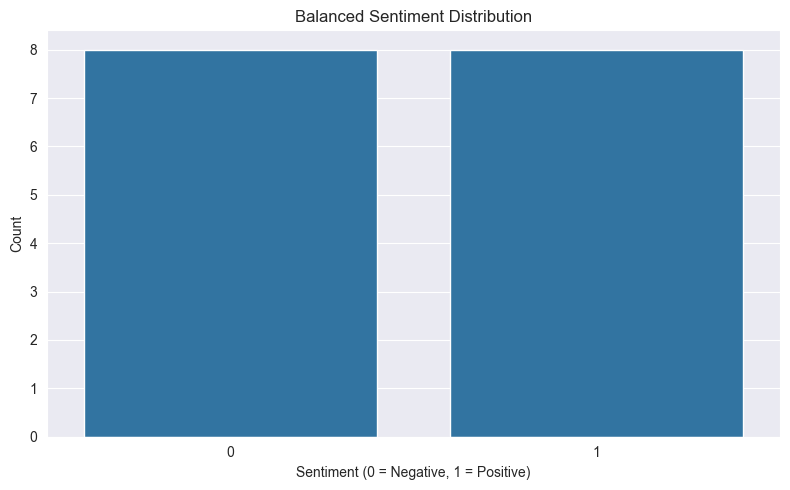

In [42]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df_balanced)
plt.title('Balanced Sentiment Distribution')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

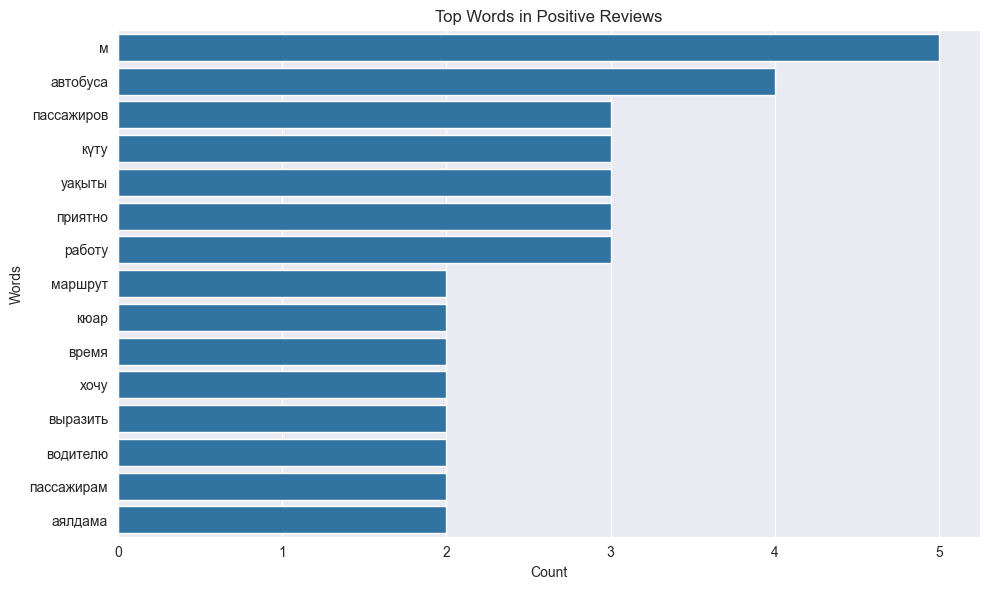

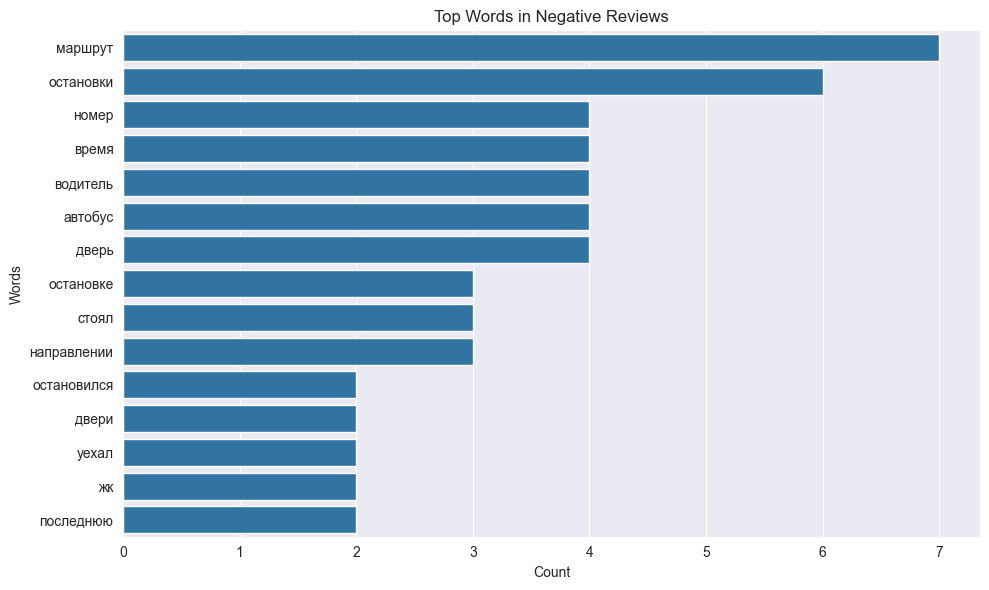

In [43]:
def tokenize(text):
    tokens = word_tokenize(text.lower())
    return [w for w in tokens if w.isalpha() and w not in stopwords.words('russian') + list(string.punctuation)]

def plot_word_frequencies(texts, title):
    words = []
    for text in texts:
        words.extend(tokenize(text))
    common = Counter(words).most_common(15)
    if not common:
        return
    words, counts = zip(*common)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()

plot_word_frequencies(df_balanced[df_balanced['label'] == 1]['processed_text'],
                      'Top Words in Positive Reviews')
plot_word_frequencies(df_balanced[df_balanced['label'] == 0]['processed_text'],
                      'Top Words in Negative Reviews')

In [44]:
X = df['processed_text']
y = df['label']

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nLogistic Regression (Stratified 5-Fold CV):")
all_reports = []
fold = 1

for train_index, test_index in skf.split(X_tfidf, y):
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    logreg = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced')
    logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test)

    print(f"\nFold {fold}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    all_reports.append((y_test, y_pred))
    fold += 1

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_tfidf, y)

final_model = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000, class_weight={0: 1, 1: 10}, random_state=42)
final_model.fit(X_tfidf, y)

logreg = final_model


Logistic Regression (Stratified 5-Fold CV):

Fold 1:
Accuracy: 0.9655
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       0.00      0.00      0.00         1

    accuracy                           0.97        29
   macro avg       0.48      0.50      0.49        29
weighted avg       0.93      0.97      0.95        29


Fold 2:
Accuracy: 0.9310
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       0.00      0.00      0.00         2

    accuracy                           0.93        29
   macro avg       0.47      0.50      0.48        29
weighted avg       0.87      0.93      0.90        29


Fold 3:
Accuracy: 0.9310
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       0.00      0.00      0.00  

Accuracy: 0.9310
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       0.00      0.00      0.00         2

    accuracy                           0.93        29
   macro avg       0.47      0.50      0.48        29
weighted avg       0.87      0.93      0.90        29



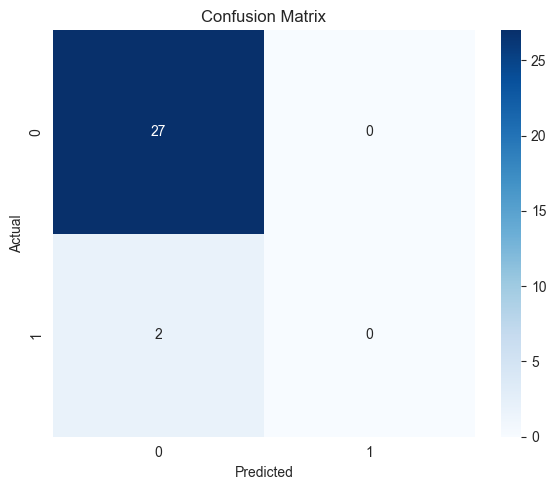

In [45]:
from sklearn.model_selection import train_test_split

X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
    X_tfidf, y, stratify=y, test_size=0.2, random_state=42
)

visual_model = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000, class_weight='balanced', random_state=42)
visual_model.fit(X_train_vis, y_train_vis)

y_pred_vis = visual_model.predict(X_test_vis)

print(f"Accuracy: {accuracy_score(y_test_vis, y_pred_vis):.4f}")
print(classification_report(y_test_vis, y_pred_vis))

cm = confusion_matrix(y_test_vis, y_pred_vis)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

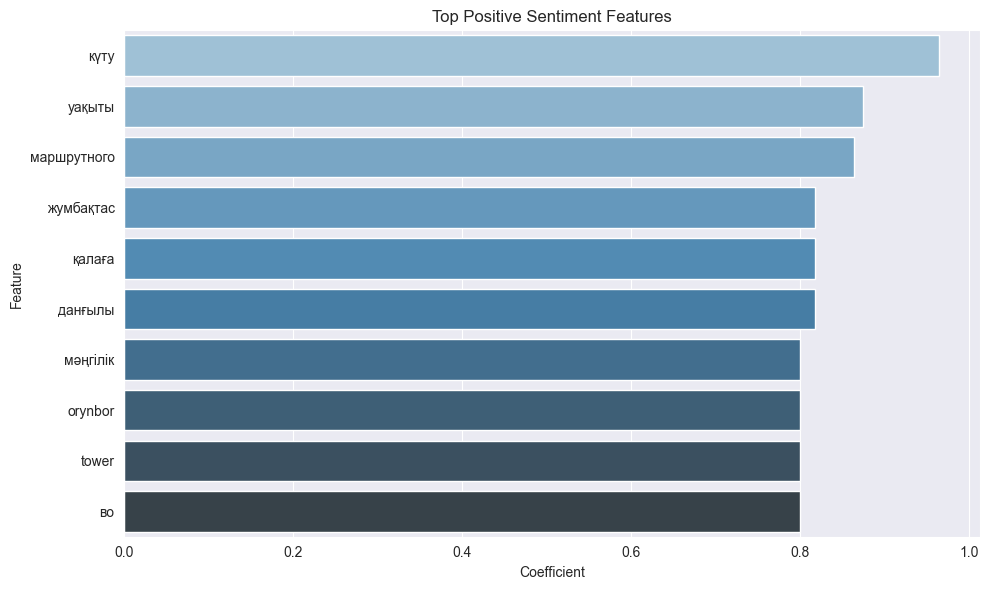

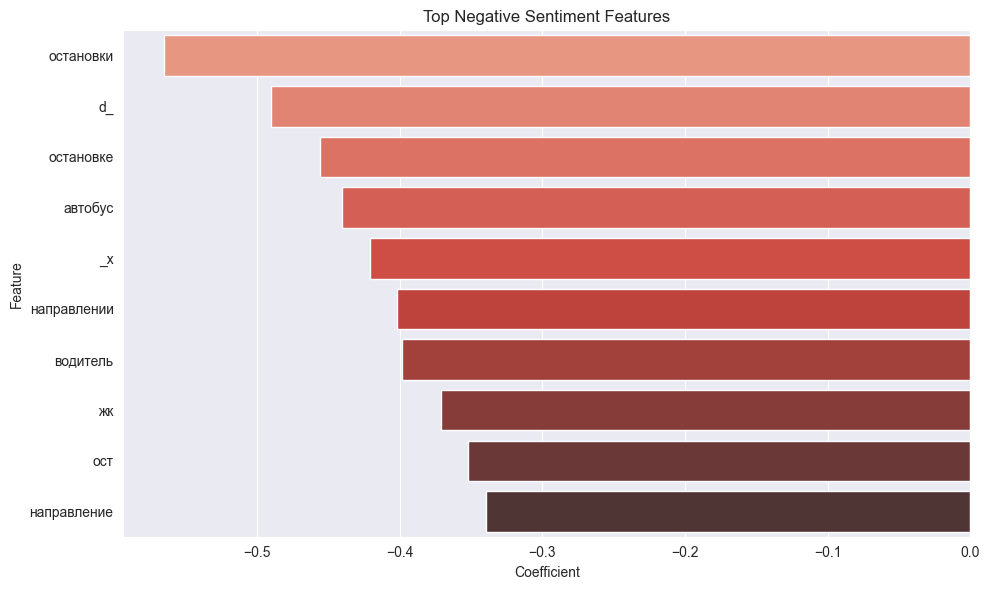

In [46]:
if hasattr(visual_model, 'coef_'):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    coefs = visual_model.coef_[0]

    top_features = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
    top_features['Abs_Coefficient'] = top_features['Coefficient'].abs()
    top_features = top_features.sort_values('Abs_Coefficient', ascending=False)

    top_pos = top_features[top_features['Coefficient'] > 0].head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=top_pos, palette='Blues_d')
    plt.title('Top Positive Sentiment Features')
    plt.tight_layout()
    plt.show()

    top_neg = top_features[top_features['Coefficient'] < 0].head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=top_neg, palette='Reds_d')
    plt.title('Top Negative Sentiment Features')
    plt.tight_layout()
    plt.show()


In [47]:
def classify_review(review_text):
    lang = detect_language(review_text)
    processed = preprocess_text(review_text, lang)
    vec = tfidf_vectorizer.transform([processed])
    return "Positive" if final_model.predict(vec)[0] == 1 else "Negative"

for i in range(len(df)):
    review = df.iloc[i]["text"]
    sentiment = classify_review(review)
    print(f"\nReview: {review[:]}")
    print(f"Sentiment: {sentiment}")


Review: № 57 маршрут, на остановке Нурлы Жол в направлении города  водитель табличку с нумерацией включил и уехал, т.е не посадил пассажиров. Время 06-00.
Sentiment: Negative

Review: 14 м/а с 6:00-6:31 нету автобуса с Нурлы жол в направлении города ,столько людей ждут стоят!
Sentiment: Negative

Review: 06:00-06:35 аралығында «Ақ-Жайық» ТД аялдамасы «Тұлпар» сауда орталығының аялдамасы бағытында МА 22 автобусы болған жоқ.
Sentiment: Negative

Review: №2,13,32, 49, 50,73 Балбала аялдамасы  Көктал ТК бағытыңа қарай  сағат 06-20 пен 06-52 кеткенге дейің желіде болмады.
Sentiment: Negative

Review: № 18 бағдар , мем/нөмір  862 . Медицинский центр аялдамасынаң  Дом Министерств бағытыңа қарай , сағат 07-05 кеткенде алдыңғы есікті ашпады , шығуға дайындалап тұрдым .
Sentiment: Negative

Review: Маршрут №51 не было автобуса с 06:55-07:30 с остановки ЖК "Орман парк" в направлении остановки Городская больница №2.
Sentiment: Negative

Review: маршрут №58 продлили до ул. Карасай батыра, этот мар